In [ ]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
OMP_NUM_THREADS=1 
import hyperopt
from hyperopt import hp
from hpsklearn import HyperoptEstimator, xgboost_classification, sgd, any_classifier
import xgboost as xgb

from yellowbrick.target import class_balance, ClassBalance
from yellowbrick.classifier import ConfusionMatrix


In [4]:
def timer(start_time=None):
    # this is customized function to print the time of performance
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [5]:
RANDOM_STATE=42

# Data
I am using the mnist dataset - images with numbers for image classification problem

In [11]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [15]:
mnist['target'].shape

(70000,)

In [16]:
# split for test, train and validation

X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=RANDOM_STATE)

In [17]:
y_train_1_class = np.array(['1' if x=='1' else '0' for x in y_train])
y_test_1_class = np.array(['1' if x=='1' else '0' for x in y_test])

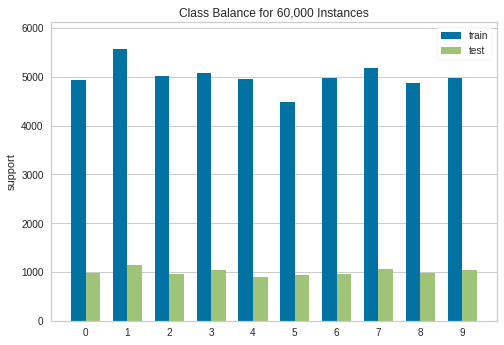

<AxesSubplot:title={'center':'Class Balance for 60,000 Instances'}, ylabel='support'>

In [18]:

# Instantiate the visualizer
visualizer = ClassBalance()
visualizer.fit(y_train, y_test)        # Fit the data to the visualizer
visualizer.show() 

# Simple classifier

/home/angelika/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/angelika/.local/lib/python3.8/site-packages/yellowbrick/classifier/prcurve.py:256: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


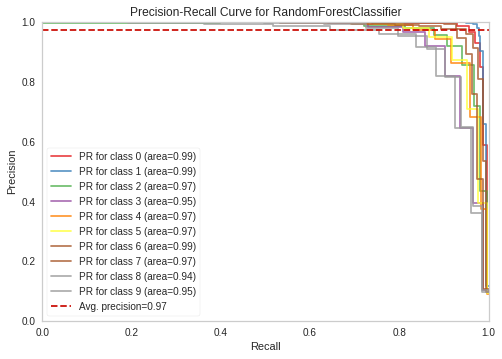

<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import PrecisionRecallCurve

# Load dataset and encode categorical variables

# Create the visualizer, fit, score, and show it
viz1 = PrecisionRecallCurve(
    RandomForestClassifier(n_estimators=10),
    per_class=True
)
viz1.fit(X_train, y_train)
viz1.score(X_test, y_test)
viz1.show()

## KNeighborsClassifier (extremly slow...)

In [56]:
neigh = KNeighborsClassifier(n_neighbors=3)

In [57]:
start_time = timer(None)
neigh.fit(X_train, y_train)
timer(start_time)


 Time taken: 0 hours 0 minutes and 8.3 seconds.


In [58]:
start_time = timer(None)
neigh.score(X_test, y_test)
timer(start_time)


 Time taken: 0 hours 10 minutes and 21.89 seconds.


In [ ]:
# choose optimal k

error_rate = []
score = []
for i in np.arange(3,15,2):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train,y_train)
    pred_i = neigh.predict(X_val)
    error_rate.append(np.mean(pred_i != y_val))
    score.append(neigh.score(X_val, y_val))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40), error_rate)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40), score)
plt.title('Error Rate vs. K Value')

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.score(X_test, y_test)

## xgboost

In [ ]:
param = {'max_depth':7, 'eta':0.1, 'objective':"multi:softmax", 'num_class':10,
         'n_estimators':20,
         'random_state':RANDOM_STATE}

xgb_cl = XGBClassifier(**param)
xgb_cl.fit(X_train, y_train)

In [ ]:
accuracy_score(xgb_cl.predict(X_test), y_test)

## parameters optimization (with RandomSearchCV)

In [ ]:
# parameters optimization

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'learning_rate': [0.1, 0.5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 7, 10],
        'objective': ["multi:softmax"],
        'num_class': [10]
        }

folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = RANDOM_STATE)

random_search = RandomizedSearchCV(bst, param_distributions=params, n_iter=param_comb, 
                                   n_jobs=3, cv=skf.split(X_train, y_train),
                                   verbose=3, 
                                   random_state=RANDOM_STATE)

# optimize
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
random_search.best_params_

In [21]:
param = {'subsample': 0.8,
 'objective': "multi:softmax",
 'num_class': 10,
 'min_child_weight': 1,
 'max_depth': 10,
 'learning_rate': 0.5,
 'colsample_bytree': 0.8,
 'random_state':RANDOM_STATE}

bst = XGBClassifier(**param)
bst.fit(X_train, y_train)
accuracy_score(bst.predict(X_test), y_test)

0.9712

/home/angelika/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/angelika/.local/lib/python3.8/site-packages/yellowbrick/classifier/base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


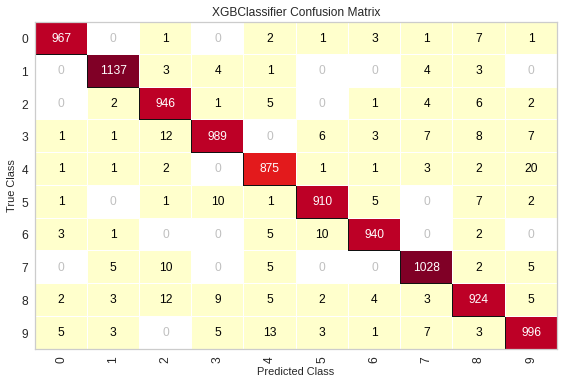

<AxesSubplot:title={'center':'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [25]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(bst, classes=[0,1,2,3,4,5,6,7,8,9])

# Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

## use hyperopt for parameters tuning

In [35]:
search_space = { 
 'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, dtype=int)),
     'learning_rate': hp.uniform('learning_rate', 0.1, 0.5),
     'subsample': hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1),
     'max_depth': hp.choice( 'max_depth', np.arange(5, 10, dtype=int)),
     'objective': hp.choice('objective', ["multi:softmax"])
}

In [37]:
param = {'subsample': 0.8,
 'objective': "multi:softmax",
 'num_class': 10,
 'min_child_weight': 1,
 'max_depth': 10,
 'learning_rate': 0.5,
 'colsample_bytree': 0.8,
 'random_state':RANDOM_STATE}

# define objective function
def hyperparameter_tuning(params):
    bst = XGBClassifier(**param)
    bst.fit(X_train, y_train)
    acc = accuracy_score(bst.predict(X_val), y_val)
    return -acc

start_time = timer(None)
best = hyperopt.fmin(fn=hyperparameter_tuning, space=search_space, algo=hyperopt.tpe.suggest, max_evals=5)
timer(start_time) 

100%|██████████| 5/5 [46:17<00:00, 555.54s/trial, best loss: -0.9771]

 Time taken: 0 hours 46 minutes and 17.7 seconds.


In [38]:
best

{'colsample_bytree': 0.8302483388599543,
 'learning_rate': 0.4647788545480812,
 'max_depth': 4,
 'min_child_weight': 5,
 'objective': 0,
 'subsample': 0.6884175199819156}

In [39]:
#Time taken: 0 hours 35 minutes and 25.14 seconds.
param = {'colsample_bytree': 0.8302483388599543,
 'learning_rate': 0.4647788545480812,
 'max_depth': 4,
 'min_child_weight': 5,
 'objective': 'multi:softmax',
 'subsample': 0.6884175199819156}

In [40]:
xgb_opt = XGBClassifier(**param)
xgb_opt.fit(X_train, y_train)
accuracy_score(xgb_opt.predict(X_test), y_test)

0.971

# hyperopt used with scikit learn to comapre different models (to chyba nie działa za dobrze...)

In [ ]:
sum(y_train_1_class=="0")/len(y_train_1_class)

In [ ]:
# build for binary classification class '1' vs the rest 

start_time = timer(None)
estim = HyperoptEstimator(classifier=any_classifier('clf'),
                          algo=hyperopt.tpe.suggest,
                          max_evals=15,
                          trial_timeout=600)

# Search the hyperparameter space based on the data

estim.fit(X_train, y_train_1_class)
timer(start_time)
#  Time taken: 0 hours 54 minutes and 14.17 seconds.

In [17]:
print( estim.best_model() )

{'learner': SVC(C=134.32777665035186, cache_size=512, coef0=24.790632854843736, degree=2.0,
    gamma=7.2979766414364535, kernel='poly', max_iter=874952942.0,
    random_state=1, tol=0.001217855207700367), 'preprocs': (Normalizer(),), 'ex_preprocs': ()}


In [18]:
# Show the results
print(estim.score(X_test, y_test))

0.9966


In [34]:
start_time = timer(None)

svc_cl = SVC(C=134.32777665035186, cache_size=512, coef0=24.790632854843736, degree=2.0,
    gamma=7.2979766414364535, kernel='poly', max_iter=874952942.0,
    random_state=RANDOM_STATE, tol=0.001217855207700367)

from sklearn.preprocessing import Normalizer

X_train_norm = Normalizer().fit_transform(X_train) 
svc_cl.fit(X_train_norm, y_train_1_class)
timer(start_time)

print(svc_cl.score(X_val, y_val))


 Time taken: 0 hours 0 minutes and 50.82 seconds.
0.1472


## validation

/home/angelika/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/angelika/.local/lib/python3.8/site-packages/yellowbrick/classifier/prcurve.py:256: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


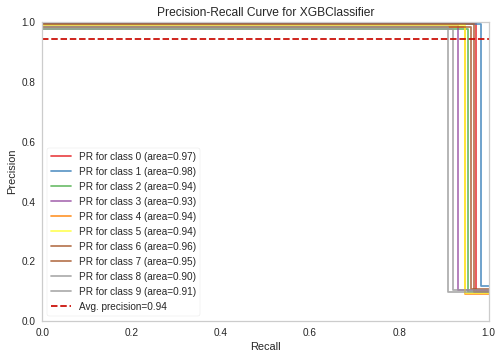

<AxesSubplot:title={'center':'Precision-Recall Curve for XGBClassifier'}, xlabel='Recall', ylabel='Precision'>

In [38]:
# Create the visualizer, fit, score, and show it
param = {'subsample': 0.8,
 'objective': "multi:softmax",
 'num_class': 10,
 'min_child_weight': 1,
 'max_depth': 10,
 'learning_rate': 0.5,
 'colsample_bytree': 0.8,
 'random_state':RANDOM_STATE}

viz = PrecisionRecallCurve(
    XGBClassifier(**param),
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

# Ensemble models

In [42]:
# ESTIMATORS
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_STATE)
svm_clf = SVC(random_state=RANDOM_STATE)


In [43]:
random_forest_clf.__class__.__name__

'RandomForestClassifier'

In [44]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, sgd_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the SVC(random_state=42)
Training the SGDClassifier(random_state=42)


In [45]:
for estimator in estimators:
    pickle.dump(estimator, open(estimator.__class__.__name__ + ".sav", 'wb'))

In [46]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.9788, 0.879]

In [47]:
voting_clf = VotingClassifier(estimators=[('rf', random_forest_clf), 
                                          ('tree', extra_trees_clf),
                                          ('svm', svm_clf),
                                          ('sgd', sgd_clf)], 
                              voting='hard')
voting_clf.fit(X_train, y_train)

voting_clf.score(X_val, y_val) 

0.9724

In [48]:
voting_clf

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('tree', ExtraTreesClassifier(random_state=42)),
                             ('svm', SVC(random_state=42)),
                             ('sgd', SGDClassifier(random_state=42))])

In [52]:
del voting_clf.estimators_[2]
del voting_clf.estimators_[3]

In [50]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 SGDClassifier(random_state=42)]

In [53]:
voting_clf.voting = "soft"

voting_clf.score(X_val, y_val) 

0.9719

In [54]:
voting_clf.score(X_test, y_test) 

0.9681

In [55]:
[estimator.score(X_test, y_test) for estimator in estimators]

[0.9645, 0.9691, 0.976, 0.8772]